In [1]:
!pip install pyspark py4j

In [2]:
#Create a Spark Session
from pyspark.sql import SparkSession

spark= SparkSession.builder.appName("description").getOrCreate()


In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# Schema defined as infering  it directly with spark alters the content in my case.
schema = StructType([
    StructField("book_id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("description", StringType(), True)
])


file_path = "/content/drive/MyDrive/Data Mining/description.csv"

# Allows for multiple lines in a given row
df_description = spark.read.option("multiline", "true").option("escape", "\"").csv(file_path, schema=schema, header=True)


# Show all rows
df_description.show(df_description.count())



+-------+--------------------+--------------------+
|book_id|                name|         description|
+-------+--------------------+--------------------+
|   4833|    The Glass Castle|A tender, moving ...|
|    590|Night (The Night ...|Born into a Jewis...|
|   4264|Angela's Ashes (F...|Imbued on every p...|
|   3361|    Eat, Pray, Love |A celebrated writ...|
|   4535|Into Thin Air: A ...|A bank of clouds ...|
|    518|Tuesdays with Morrie|Maybe it was a gr...|
|   3781|Running with Scis...|The true story of...|
|   3190|       Into the Wild|In April 1992 a y...|
|   3147|I Know Why the Ca...|Sent by their mot...|
|    225|A Child Called "I...|This book chronic...|
|   3035|Chickens, Mules a...|Perhaps if Joe an...|
|     99|Persepolis: The S...|Wise, funny, and ...|
|   3594|The Autobiography...|Through a life of...|
|   4971|The Hiding Place:...|At one time Corri...|
|   1381|All Creatures Gre...|Delve into the ma...|
|   3099|         Confessions|Augustine's Confe...|
|     45|Me 

Drop null values

In [4]:
# Drop NULL values from the DataFrame
df_description= df_description.na.drop()

**Resulting Rows**

After dropping all the NULL values, I am left with 122 ROWS of DATA.

In [5]:
df_description.count()

122

In [6]:
df_description.show(df_description.count())

+-------+--------------------+--------------------+
|book_id|                name|         description|
+-------+--------------------+--------------------+
|   4833|    The Glass Castle|A tender, moving ...|
|    590|Night (The Night ...|Born into a Jewis...|
|   4264|Angela's Ashes (F...|Imbued on every p...|
|   3361|    Eat, Pray, Love |A celebrated writ...|
|   4535|Into Thin Air: A ...|A bank of clouds ...|
|    518|Tuesdays with Morrie|Maybe it was a gr...|
|   3781|Running with Scis...|The true story of...|
|   3190|       Into the Wild|In April 1992 a y...|
|   3147|I Know Why the Ca...|Sent by their mot...|
|    225|A Child Called "I...|This book chronic...|
|   3035|Chickens, Mules a...|Perhaps if Joe an...|
|     99|Persepolis: The S...|Wise, funny, and ...|
|   3594|The Autobiography...|Through a life of...|
|   4971|The Hiding Place:...|At one time Corri...|
|   1381|All Creatures Gre...|Delve into the ma...|
|   3099|         Confessions|Augustine's Confe...|
|     45|Me 

**Tokenize Data/Remove stopwords&punctuation**

In [7]:
from pyspark.ml.feature import HashingTF, IDF, RegexTokenizer, StopWordsRemover

from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark.sql.types import ArrayType, StringType
import string




# Tokenize the text and remove white spaces
regexTokenizer = RegexTokenizer(inputCol="description", outputCol="words", pattern="\s+")

words = regexTokenizer.transform(df_description)


# Remove spaces and punctuation
remove_spaces_udf = udf(lambda tokens: [token.replace(" ", "").translate(str.maketrans("", "", string.punctuation)) for token in tokens], ArrayType(StringType()))

words = words.withColumn("words", remove_spaces_udf(col("words")))

# Remove stop words
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
words = stopwords_remover.transform(words)

# Result
words.select("book_id", "filtered_words").show(truncate=False)


+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Lemmatize**

In [8]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
import spacy


nlp = spacy.load("en_core_web_sm")

def lemmatize_tokens(tokens):
    return [token.lemma_ for token in nlp(" ".join(tokens))]

lemmatize_udf = udf(lemmatize_tokens, ArrayType(StringType()))
words = words.withColumn("lemmatized_words", lemmatize_udf(col("filtered_words")))


In [9]:
words.select("book_id", "lemmatized_words").show(10, truncate=False)


+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**Vectorize Tokenized Data**


In Spark ML, TF-IDF is separate into two parts: TF (+hashing) and IDF. TF: HashingTF is a Transformer which takes sets of terms and converts those sets into fixed-length feature vectors.


In [10]:
from pyspark.ml.feature import HashingTF, IDF

# Apply TF-IDF
hashingTF = HashingTF(inputCol="lemmatized_words", outputCol="rawFeatures", numFeatures=20)


idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(hashingTF.transform(words))
idf_data = idf_model.transform(hashingTF.transform(words))




**Reduce Dimensions**

**Training Data**

Cleaned Data goes upto 122 rows.
For training, I picked upto 121 rows to represent the first 121 books as the book_id is not in any order.

In [11]:
train_data = idf_data.limit(121)



In [12]:
train_data.count()

121

**K-Means Algorithm - 10 clusters**

Partition based clustering was used as we had provided with the number of clusters required in the question.
KMeans method was used as that's the only method I was familiar with.

In [13]:
#
kmeans = KMeans(k=10, seed=1, featuresCol="features", predictionCol="cluster", maxIter=50)

model = kmeans.fit(train_data)

In [14]:
terms = []
for i in range(3):
    cluster_center = model.clusterCenters()[i]
    cluster_terms = [f"term_{j}" for j in sorted(range(len(cluster_center)), key=lambda x: cluster_center[x], reverse=True)]

    terms.append(cluster_terms)
    print(f"Cluster {i + 1} Terms : {cluster_terms}")

Cluster 1 Terms : ['term_11', 'term_16', 'term_2', 'term_12', 'term_14', 'term_9', 'term_18', 'term_3', 'term_0', 'term_7', 'term_6', 'term_13', 'term_5', 'term_17', 'term_10', 'term_4', 'term_15', 'term_19', 'term_1', 'term_8']
Cluster 2 Terms : ['term_16', 'term_7', 'term_18', 'term_0', 'term_3', 'term_14', 'term_5', 'term_11', 'term_15', 'term_6', 'term_13', 'term_12', 'term_2', 'term_9', 'term_1', 'term_8', 'term_10', 'term_4', 'term_17', 'term_19']
Cluster 3 Terms : ['term_11', 'term_4', 'term_12', 'term_17', 'term_6', 'term_1', 'term_19', 'term_10', 'term_2', 'term_5', 'term_18', 'term_15', 'term_8', 'term_16', 'term_3', 'term_9', 'term_7', 'term_0', 'term_14', 'term_13']


**Please Note**

The question asks for the 136th book. However, for my case, after dropping all the NULL values I have 122 books left from original 144 rows. I used 121 of them for Training and the Last one(122) for Testing.

Since there is no order for *book_id*, I selected the last item which is the 122nd book.
Alternative approach is to look at the 122nd's *book_id* and use that.

In [15]:
row_122 = idf_data.limit(122).collect()[-1]
row_122

Row(book_id=1545, name='Unprocessed: How to achieve vibrant health and your ideal weight.', description='Chef AJ has a unique ability to create healthy foods that taste great. Whether you want to lower your cholesterol, prevent or reverse many common lifestyle diseases, lose weight or just look and feel great, Chef AJ can show you how to incorporate more fresh fruits and vegetables in your diet in ways that are easy, delicious and fun.', words=['chef', 'aj', 'has', 'a', 'unique', 'ability', 'to', 'create', 'healthy', 'foods', 'that', 'taste', 'great', 'whether', 'you', 'want', 'to', 'lower', 'your', 'cholesterol', 'prevent', 'or', 'reverse', 'many', 'common', 'lifestyle', 'diseases', 'lose', 'weight', 'or', 'just', 'look', 'and', 'feel', 'great', 'chef', 'aj', 'can', 'show', 'you', 'how', 'to', 'incorporate', 'more', 'fresh', 'fruits', 'and', 'vegetables', 'in', 'your', 'diet', 'in', 'ways', 'that', 'are', 'easy', 'delicious', 'and', 'fun'], filtered_words=['chef', 'aj', 'unique', 'abi

Approach 1 : Specifying by row number

In [16]:
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row

row_data = Row(features=row_122["features"])

single_row_df = spark.createDataFrame([row_data])

# Model used to make prediction of the 122nd book
prediction_122 = model.transform(single_row_df).select("cluster").collect()[0]["cluster"]

print(f"The Book in 122nd row belongs to Cluster: {prediction_122}")


The Book in 122nd row belongs to Cluster: 0


Approach 2 : Specifying the ***122nd book's book_id*** and then filter it.

In [17]:
book_id = 1545
try:
    row_data = idf_data.filter(idf_data["book_id"] == book_id).select("features").collect()[0]

    row_data = Row(features=row_data["features"])
    single_row_df = spark.createDataFrame([row_data])

    prediction = model.transform(single_row_df).select("cluster").collect()[0]["cluster"]

    print(f"The Book with book_id {book_id} belongs to Cluster: {prediction}")

except IndexError:
    print(f"Book with book_id {book_id} not found in vectorized_data.")
except Exception as e:
    print(f"An error occurred: {e}")

The Book with book_id 1545 belongs to Cluster: 0


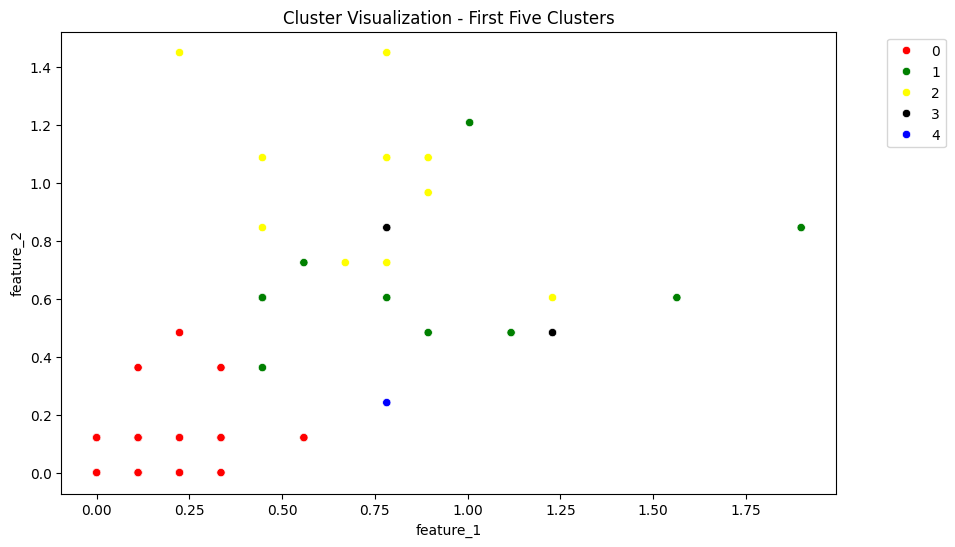

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

predictions = model.transform(idf_data)

# First five clusters

clusters = predictions.filter(col("cluster").between(0, 4))

clusters_pd = clusters.select("name", "cluster", "features").toPandas()

# Dimensions of Vectorized_data are used to do the plotting
# Here , I reduced the dimensions from 20 to 2
clusters_pd["feature_1"] = clusters_pd["features"].apply(lambda x: x[0] if len(x) > 0 else None)
clusters_pd["feature_2"] = clusters_pd["features"].apply(lambda x: x[1] if len(x) > 1 else None)

# Colors to use
custom_palette = {0: 'red', 1: 'green', 2: 'yellow', 3: 'black', 4: 'blue'}



plt.figure(figsize=(10, 6))

# Scatter plot
scatter_plot = sns.scatterplot(x="feature_1", y="feature_2", hue="cluster", data=clusters_pd, palette=custom_palette, legend="full")

scatter_plot.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.title("Cluster Visualization - First Five Clusters")
plt.show()


**Model Evaluation**

In [19]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(predictionCol="cluster", featuresCol="features", metricName="silhouette")

silhouette_score = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette_score}")


Silhouette Score: 0.13661917390906717


A silhouette score of 0.137 indicates a fair distance of  separation between clusters, but it is not the best.Some suggestions to enhance this include :  

1. **Optimizing the Number of Clusters (k):**  In our case, it was already given. However, using methods such as elbow method might help in establishing an optimal cluster value.


2. **Trying Different Clustering Algorithms:**
   - Experimenting with alternative clustering algorithms available in Spark, such as Bisecting KMeans, Gaussian Mixture Model (GMM), or hierarchical clustering. Different algorithms may perform better on specific types of data.

3. **Optimal Dimensionality Reduction:**

